# MLDA experiment in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

In [2]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")


GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
gpu_stream = cuda.Stream()

Utils

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import *

In [7]:
truth_path = "/home/florianb/havvarsel/multilevelDA/scripts/DataAssimilation/BasinTruth/2023-06-22T13_47_48"

## Case 

In [8]:
L = 9

In [9]:
from utils.BasinParameters import * 

In [10]:
lvl_grid_args = initGridSpecs(L)

args = {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } 

In [11]:
data_args = make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) 


In [12]:
Ne = 50

In [13]:
from utils.BasinSL import * 

In [14]:
SL_ensemble = initSLensemble(Ne, args, data_args, sample_args, 
                             init_model_error_basis_args, 
                             sim_model_error_basis_args, sim_model_error_timestep)

In [15]:
precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( GCweights(SL_ensemble, obs_x, obs_y, r) )

### Data Assimilation

In [16]:
while SL_ensemble[0].t < T_da:
    # Forward step
    SLstepToObservation(SL_ensemble, SL_ensemble[0].t + da_timestep)
    print(SL_ensemble[0].t)

    # DA step
    true_eta, true_hu, true_hv = np.load(truth_path+"/truth_"+str(int(SL_ensemble[0].t))+".npy")

    for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
        Hx, Hy = SLobsCoord2obsIdx(SL_ensemble, obs_x, obs_y)
        obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)
        
        prior = copy.deepcopy(SLdownload(SL_ensemble))

        SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, 
                                obs_var=slice(1,3), relax_factor=relax_factor, 
                                localisation_weights=precomp_GC[h])

900.0
1800.0
2700.0
3600.0
4500.0
5400.0
6300.0
7200.0
8100.0
9000.0
9900.0
10800.0
11700.0
12600.0
13500.0
14400.0
15300.0
16200.0
17100.0
18000.0
18900.0
19800.0
20700.0
21600.0


In [21]:
def plot_diagnostics():
    _, axs_truth = imshow3( np.load(truth_path+"/truth_"+str(int(SL_ensemble[0].t))+".npy") )
    _, axs_mean  = imshow3(SLestimate(SL_ensemble, np.mean))
    _, axs_var   = imshow3var(SLestimate(SL_ensemble, np.var))


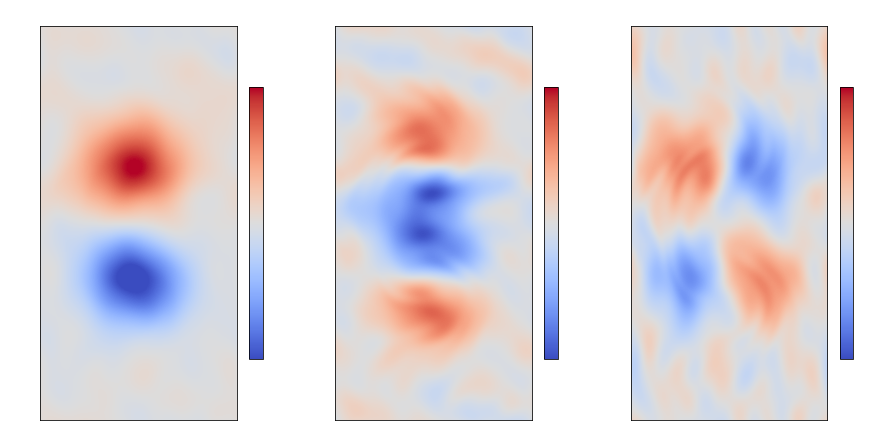

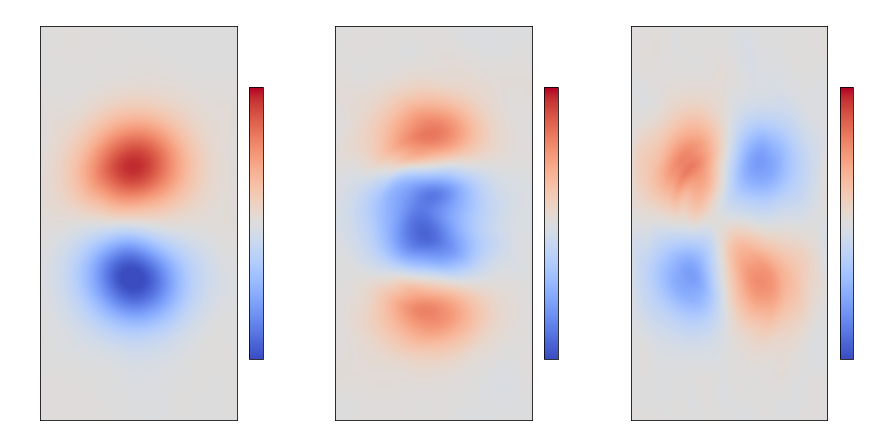

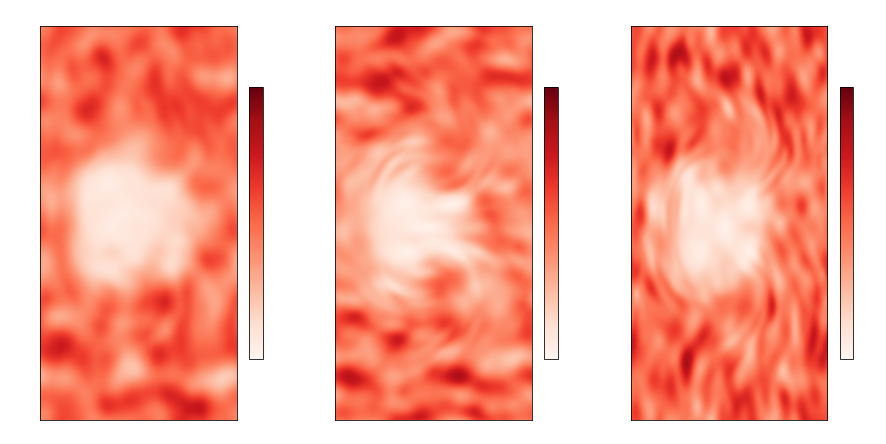

In [22]:
plot_diagnostics()

Different Kalman Gains

In [27]:
def plot_SL_K(SL_K):
    vlims = [0.005, 0.5, 0.5]

    fig, axs = plt.subplots(2, 3, figsize=(10,10))

    for i in range(2):
        
        for j in range(3):
            ax = axs[i,j]
            
            im = ax.imshow(SL_K[j,:,:,i], vmin=-vlims[j],vmax=vlims[j], cmap="coolwarm")
            ax.scatter(Hx, Hy, marker="x", c="black")
            plt.colorbar(im, ax=ax, shrink=0.5)

    fig.suptitle("Kalman Gain")

In [28]:
h = 0
obs_x, obs_y = obs_xs[h], obs_ys[h]
Hx, Hy = SLobsCoord2obsIdx(SL_ensemble,obs_x, obs_y)

In [29]:
SLupload(SL_ensemble, prior)

SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, 
                        obs_var=slice(1,3), relax_factor=relax_factor, 
                        localisation_weights=precomp_GC[h])

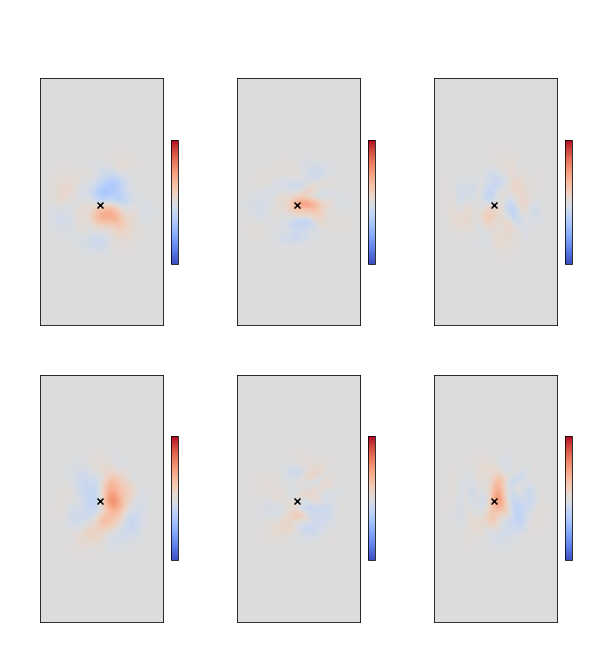

In [30]:
plot_SL_K(SL_K)

In [35]:
SLupload(SL_ensemble, prior)

SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, 
                    obs_var=slice(1,3), relax_factor=relax_factor, 
                    localisation_weights=np.ones((args["ny"],args["nx"])))

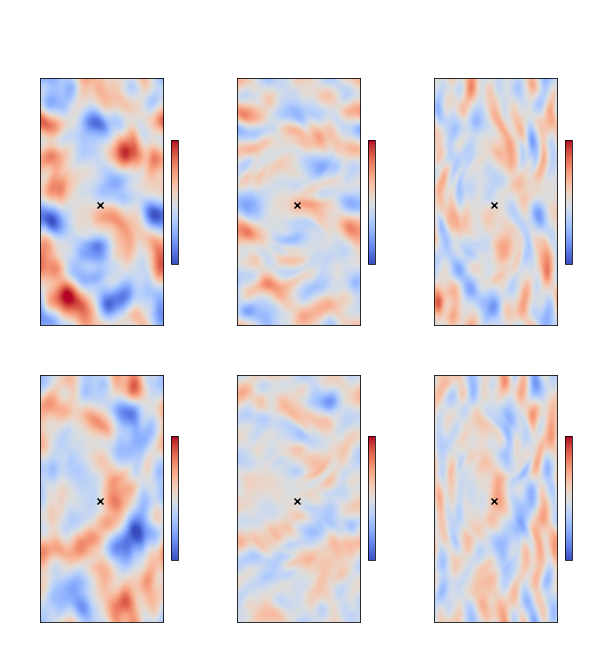

In [36]:
plot_SL_K(SL_K)